# Online Convex Optimization

Данные будем брать из этого датасета:
https://archive.ics.uci.edu/ml/datasets/spambase

In [1]:
# подключение необходимых библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
%matplotlib inline

In [2]:
spam_data = pd.read_csv('spambase.data', header=None)

d = 55
spam_data.columns = np.arange(0, 58)
print(d)
spam_data.head()

55


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Заметим, что в данном датасете сначала идут те сообщения, которые являются спамом, а потом - те, которые не являются. Это может негативно сказаться на качестве работы алгоритмов. Поэтому сделаем `shuffle` строк датасета при помощи функции `pandas.sample`.

In [3]:
spam_data = spam_data.sample(frac=1)
spad_data = pd.DataFrame(spam_data.values, columns=spam_data.columns)
spam_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
1812,0.00,0.31,0.42,0.0,0.00,0.10,0.00,0.52,0.21,0.52,...,0.000,0.016,0.000,0.887,0.032,0.049,3.446,318,1003,1
174,0.00,0.00,0.00,0.0,0.00,0.78,0.00,2.34,0.00,0.78,...,0.000,0.000,0.000,0.889,0.000,0.000,2.130,15,49,1
1706,0.41,0.00,0.41,0.0,0.41,0.00,0.00,0.00,0.41,0.83,...,0.000,0.000,0.000,0.000,0.000,0.676,9.444,54,255,1
2423,0.05,0.00,0.10,0.0,0.00,0.10,0.00,0.05,0.49,0.00,...,0.308,0.136,0.078,0.000,0.014,0.000,3.715,107,1386,0
4588,0.00,0.00,3.03,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,1.111,2,10,0
3688,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1,3,0
1121,0.50,0.25,0.42,0.0,0.08,0.23,0.02,0.35,0.35,0.69,...,0.000,0.069,0.000,0.325,0.523,0.124,6.723,445,4128,1
2791,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.735,0.000,0.735,0.000,0.000,2.571,10,18,0
2398,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,5.200,17,26,0
2062,0.34,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.34,0.68,...,0.052,0.420,0.052,0.000,0.000,0.052,2.604,13,250,0


Для дальнейшего применения алгоритмов разобьём данные на значения признаков и столбец целевой переменной.

In [4]:
X = spam_data[np.arange(d)].values
y = spam_data[57].values

### Online Gradient Descent

Для начала, чтобы убедиться в адекватности построенной модели, применим online градиентный спуск.
Запустим его на разных начальных приближениях.

**Замечание.**

Для получения значений `regret`ов был использован пакет для выпуклой оптимизации `cvxpy`, который получает ответ достаточно медленно. По этой причине я считал эти значения не на всех итерациях алгоритма.

Чтобы не считать значения `regret`, можно не передавать 3 параметр в функцию `online_gradient_descent`.

In [5]:
R = 1.0
G = 0.5
D = 2.0 * R

M = 100.0*R

#объявление необходимых функций

def proection(x):
    if np.linalg.norm(x) <= R:
        return x
    return x / np.linalg.norm(x) * R

def grad(x, w):
    return (np.dot(x, w) + M) / (2.0*M**2) * w

def calc_opt_value(x_list, y_list):
    w = cvx.Variable(d)
    #print(x_list)
    #print(y_list)
    prob = cvx.Problem(cvx.Minimize(cvx.sum_squares(y_list - (x_list*w + M) / (2*M))), 
                       [cvx.sum_squares(w) <= R**2])

    result = prob.solve(solver=cvx.SCS, verbose=False, eps=0.01)
    return result

def calc_regret(cur_sum, x_list, y_list):
    return cur_sum - calc_opt_value(x_list, y_list)

def online_gradient_descent(x0, T, regrets=None, param_G=G, param_D=D):
    x = x0
    t = 1
    cur_sum = 0
    x_list = []

    while t <= T:
        alpha = param_D / (param_G * float(t)**0.5)
        new_x = proection(x - alpha * grad(x, X[t - 1]))
        
        x = new_x
        x_list.append(x)
        cur_sum += (y[t - 1] - (np.dot(X[t - 1], x) + M) / (2*M))**2
        if not (regrets is None) and ((t == T) or (t % 500 == 0)):
            regrets.append((t, calc_regret(cur_sum, np.array(x_list), y[:t])))
        t += 1
    return x

In [6]:
def try_online_gd(x0):
    regrets = []
    a = online_gradient_descent(x0, len(spam_data), regrets)
    dots = np.dot(X, a)
    predict = (np.sign(dots) + 1.0) / 2
    regrets = np.array(regrets)

    success = len(predict[predict == y])
    print('accuracy: ', float(success) / len(spam_data))
    print('regrets: ', regrets[:, 1])
    return (regrets[:, 0], regrets[:, 1])
    
regret_matr = []
regret_matr.append(try_online_gd(np.zeros(d)))
regret_matr.append(try_online_gd(np.ones(d) * R / (float(d)**0.5)))
regret_matr.append(try_online_gd(np.hstack(([R], np.zeros(d - 1)))))

Failure:Interrupted


SolverError: Solver 'SCS' failed. Try another solver or solve with verbose=True for more information. Try recentering the problem data around 0 and rescaling to reduce the dynamic range.

Построим графики посчитанных значений $regret$ в каждом случае.

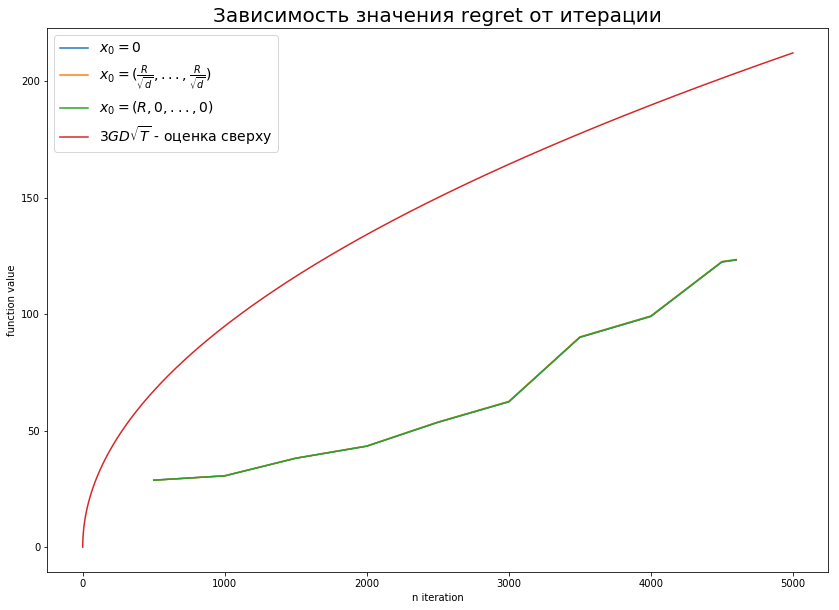

In [119]:
def plot_gd_regrets(regrets, labels=['$x_0=0$', 
                                  '$x_0=(\\frac{R}{\\sqrt{d}}, ..., \\frac{R}{\\sqrt{d}})$',
                                  '$x_0=(R, 0, ..., 0)$']):
    plt.figure(figsize=(14, 10))
    for (regret, label) in zip(regrets, labels):
        plt.plot(regret[0], regret[1], label=label)
        
    grid = np.linspace(0, 5000, 100000)
    plt.plot(grid, 3.0*D*G*(grid**0.5), label=u'$3GD\\sqrt{T}$ - оценка сверху')
        
    plt.legend(fontsize=14)
    plt.title(u'Зависимость значения regret от итерации', fontsize=20)
    plt.xlabel('n iteration')
    plt.ylabel('function value')
    plt.show()

plot_gd_regrets(np.array(regret_matr))

**Вывод.**

1) Как можно увидеть, от начального приближения точность алгоритма не зависит. И графики зависимости значения $regret$ от номера итерации получились при всех трёх рассмотренных начальных приближениях похожими.

2) Теоретические оценки для верхней границы значений $regret$ оказались выполнены, что показывает достаточно.

In [7]:
import ipywidgets as widgets

def display_widget(ip):
    # отображаем слайдеры группами
    display(widgets.HBox(ip.children[:2]))
    display(widgets.HBox(ip.children[2:4]))
    display(widgets.HBox(ip.children[4:6]))
    if len(ip.children) > 7:
        display(widgets.HBox(ip.children[6:len(ip.children)-1]))
    # отображаем вывод функции
    display(ip.children[-1])

    ip.update()  # чтобы функция запустилась до первого изменения слайдеров

In [8]:
def const_step_OGD(param_G, param_D):
    x = online_gradient_descent(np.zeros(d), len(spam_data), regrets=None,
                                param_G=param_G, param_D=param_D)
    print(x)
    dots = np.dot(X, x)
    predict = (np.sign(dots) + 1.0) / 2
    success = len(predict[predict == y])
    print('accuracy: ', float(success) / len(spam_data))

ip = widgets.interactive(const_step_OGD,
                         param_G=widgets.FloatSlider(min=0.5, max=10, step=0.1, value=0.5),
                         param_D=widgets.FloatSlider(min=2, max=10, step=0.1, value=2));

display_widget(ip)

HBox(children=(FloatSlider(value=0.5, description='param_G', max=10.0, min=0.5), FloatSlider(value=2.0, description='param_D', max=10.0, min=2.0)))

HBox(children=(Output(),))

HBox()

Output()

### Online Stochastic Gradient Descent

### Online Newton Step

Для начала научимся решать задачу методом проекций градиента. Воспользуемся уже написанной функцией поиска проекции на шар.

In [ ]:
def calc_armijo_step(f, gradf, h, x):
    alpha = 1
    beta = 0.1
    rho = 0.9
    while (f(proection(x - alpha * h)) >= f(x) + beta * alpha * np.array(gradf(x)).dot(h)):
        alpha *= rho
    return alpha

def matr_dist(A, x, y):
    return (x - y).T.dot(A.dot(x - y))

def matr_dist_grad(A, x, y):
    return 2 * A * (x - y)

#Решим задачу минимизации, выбирая шаг по правилу Армихо
def find_A_proection(A, y, tol=1e-3, max_iter=10000):
    x = np.zeros(d)
    y = np.array(y)
    x[0] = R
    it = 0
    while it < max_iter:
        gradient = matr_dist_grad(A, x, y)
        alpha = calc_armijo_step(f, gradf, gradient, x)
        x_prev = x.copy()
        x = proj(x - alpha * gradient)
        if np.linalg.norm(x - x_prev) < tol:
            break
        it += 1
    return x

alpha = 1 / M^2
gamma = 1/2 * np.min(1/4./G/D, alpha)
const_step = 1 / gamma
epsilon = 1 / gamma**2 / D**2

def const_step():
    return 1. / gamma

#returns regrets found
def find_ons_solutions(x0, T, calc_step=const_step):
    x = x0
    A = epsilon * np.eye(d)
    A_rev = 1 / epsilin * np.eye(d)
    for t in range(T):
        